# California Recall Simulation - Visualizing the Results

In [48]:
from pref_voting.voting_methods import *
from pref_voting.generate_spatial_profiles import *

import numpy as np
import pandas as pd

from multiprocess import Pool, cpu_count

import matplotlib.pyplot as plt
import seaborn as sns

import os
import pickle
import gc

from tqdm.notebook import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Function to plot specified y-values with error bars on the same graph
def plot_with_error(df, x_labels, y_columns, error_columns, filename):

    fontsize = 12
    # Filter and sort the data to match x_labels order
    df_sorted = df[df['concentration_parameter'].isin(x_labels)].copy()
    df_sorted['x_order'] = df_sorted['concentration_parameter'].apply(lambda x: x_labels.index(x))
    df_sorted = df_sorted.sort_values('x_order')

    # Create numerical indices for x-axis
    x_values = np.arange(len(x_labels))

    # Plotting setup
    plt.figure(figsize=(8, 6))

    # Iterate over each y-value and error column to plot them
    for y_column, error_column in zip(y_columns, error_columns):
        # Extract relevant y-values and error values
        pr_values = df_sorted[y_column].values


        # Convert to numeric and ensure finite values
        pr_values = np.nan_to_num(pd.to_numeric(pr_values, errors='coerce'), nan=0.0, posinf=0.0, neginf=0.0)

        # Plot the data with shaded error regions
        plt.plot(x_values, pr_values, marker='o', label="Recall" if y_column == 'pr_recall' else ("Majority prefers incumbent to replacement, conditional on a recall" if y_column == "conditional_pr_incumbent_maj_pref_winner_after_recall" else "Recall and a majority prefers incumbent to replacement"))

        if error_column != "":
            error_values = df_sorted[error_column].values
            error_values = np.nan_to_num(pd.to_numeric(error_values, errors='coerce'), nan=0.0, posinf=0.0, neginf=0.0)
            plt.fill_between(x_values, pr_values - error_values, pr_values + error_values, alpha=0.2)

    # Formatting the plot
    # Convert x_labels to remove trailing .0 if present
    formatted_labels = [str(int(label)) if label == int(label) else str(label) for label in x_labels]
    plt.xticks(x_values, formatted_labels, rotation=0, fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.xlabel('Concentration Parameter ($\\lambda$)', fontsize=fontsize)
    plt.ylabel('Frequency', fontsize=fontsize)
    plt.ylim(-0.01, 1)
    plt.title('') #f'{title}')


    plt.legend(frameon=False, loc='upper center', fontsize=fontsize)#, bbox_to_anchor=(0.15, 1))   
    sns.despine()
    plt.grid(False)
    plt.tight_layout()
    plt.savefig(f"{filename}")
    # Display the plot
    plt.show()



Processing: manipulation_level=1.0, recall_decision_type=sincere, replacement_rule=sincere


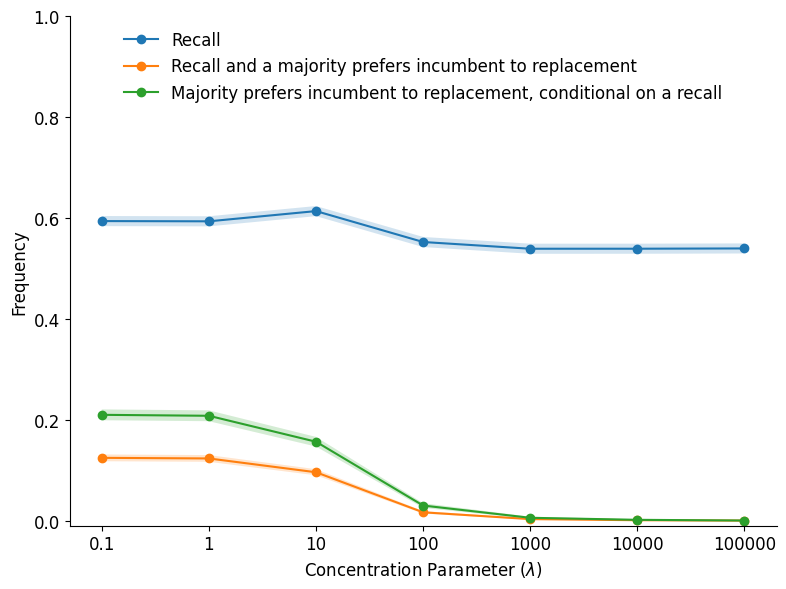

Processing: manipulation_level=1.0, recall_decision_type=strategic, replacement_rule=strategic-top-two


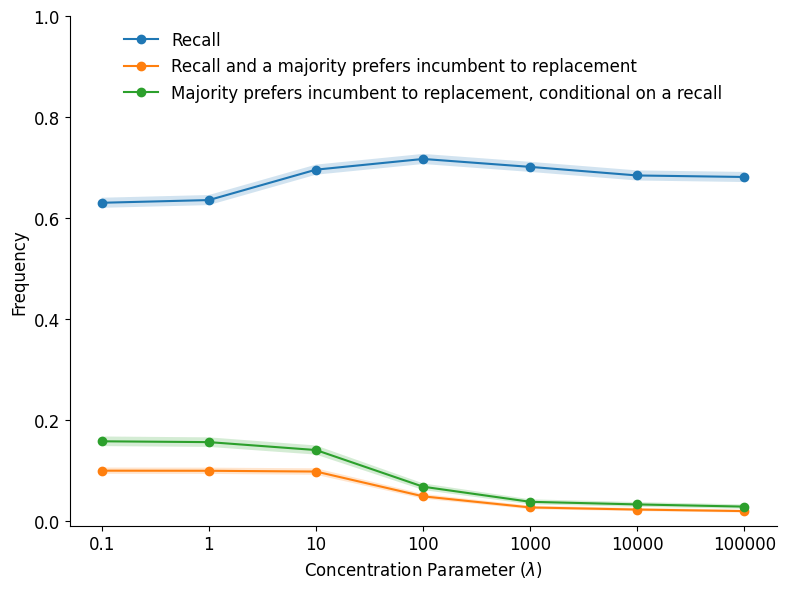

Processing: manipulation_level=0.0, recall_decision_type=strategic, replacement_rule=strategic-top-two


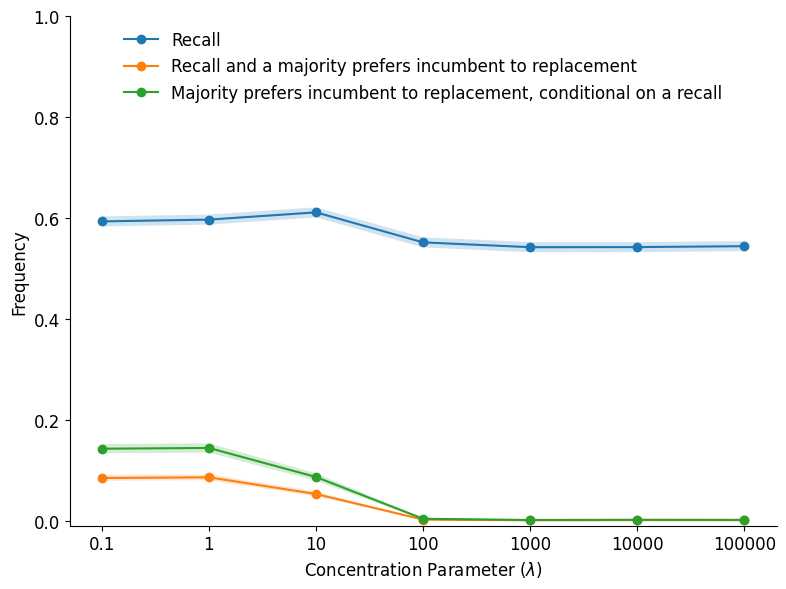

In [4]:
main_dir='.' #'multiple_candidates2'
sub_dir = 'hpc' #'incumbent2_opposition5'
std_str='0.5'

csv_data =  f'{main_dir}/{sub_dir}/data_from_zaratan' #f'data_{left_right_split}'

graph_types = [
    (1.0, 'sincere', 'sincere'), 
    (1.0, 'strategic', 'strategic-top-two'),
    (0.0, 'strategic', 'strategic-top-two'),
]

for manipulation_level, recall_decision_type, replacement_rule in graph_types:
    print(f'Processing: manipulation_level={manipulation_level}, recall_decision_type={recall_decision_type}, replacement_rule={replacement_rule}')
    # manipulation_level = 1.0
    # recall_decision_type = 'sincere' #sincere' #'strategic'
    # replacement_rule = 'sincere' #sincere' #'strategic-top-two'

    filename = f'graphs_NEW/{sub_dir}_std{std_str}_sim_diff_probs_{recall_decision_type}_{replacement_rule}_{manipulation_level}.pdf'
    title = f'Multiple Probabilities: recall decision type: {recall_decision_type}, replacement rule: {replacement_rule}, manipulation level: {manipulation_level}, {sub_dir}, std: {std_str}'

    dfs = []
    for file in glob.glob(f"./{csv_data}/*_{std_str}_*.csv"):
        df = pd.read_csv(file)
        dfs.append(df)
    df = pd.concat(dfs, ignore_index=True)
    # remove duplicate rows
    df = df.drop_duplicates()

    x_labels = [0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]

    df=df[df['concentration_parameter'].isin(x_labels)]
    df=df[df['recall_decision_type'] == recall_decision_type]
    df=df[df['replacement_rule'] == replacement_rule]
    df=df[df['manipulation_level'] == manipulation_level]


    df['conditional_probability'] = df['pr_incumbent_maj_pref_winner_after_recall'] / df['pr_recall']


    df['conditional_prob_diff'] = df['conditional_probability'] - df['conditional_pr_incumbent_maj_pref_winner_after_recall']

    # Define x-axis labels in the correct order
    x_labels = sorted(df['concentration_parameter'])

    # Specify the column names for y-values and errors
    y_columns = [
        "pr_recall", 
        "pr_incumbent_maj_pref_winner_after_recall", 
        "conditional_pr_incumbent_maj_pref_winner_after_recall"
        ]
    error_columns = [
        "err_recall_events", 
        "err_incumbent_maj_pref_winner_after_recall_events", 
        "err_conditional_pr_incumbent_maj_pref_winner_after_recall"
        ]

    # Call the plotting function
    plot_with_error(df, x_labels, y_columns, error_columns, filename)



In [237]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

def plot_conditional_for_opponents(
    df,
    x_labels,
    title,
    filename,
    x_col='concentration_parameter',
    opp_col='num_cands_opposition_party',
    y_col='conditional_pr_incumbent_maj_pref_winner_after_recall',
    err_col='err_conditional_pr_incumbent_maj_pref_winner_after_recall'
):
    fontsize = 12
    plt.figure(figsize=(8, 7))

    # 1) auto-detect all opponent sizes and sort
    opponent_sizes = sorted(df[opp_col].unique())
    n = len(opponent_sizes)

    # 2) pick a qualitative palette, plus a set of linestyles & markers
    colors     = sns.color_palette("tab10", n_colors=n)
    linestyles = ['-', '--', '-.', ':']
    markers    = ['o', 's', '^', 'D', 'v', 'P', 'X', '*']

    for i, opp in enumerate(opponent_sizes):
        df_sub = df[df[opp_col] == opp]
        if df_sub.empty:
            continue

        y_col = 'conditional_pr_incumbent_maj_pref_winner_after_recall'
        err_col = 'err_conditional_pr_incumbent_maj_pref_winner_after_recall'

        # aggregate & reindex as before
        agg = (
            df_sub.groupby(x_col)[[y_col, err_col]]
                  .mean()
                  .reindex(x_labels)
        )
        agg[y_col] = agg[y_col].ffill().bfill()
        agg[err_col] = agg[err_col].fillna(0.0)

        x = np.arange(len(x_labels))
        y = agg[y_col].to_numpy()
        e = agg[err_col].to_numpy()

        # pick style for this index
        c  = colors[i]
        ls = linestyles[i % len(linestyles)]
        mk = markers[i % len(markers)]

        plt.plot(
            x, y,
            #marker=mk,
            #linestyle=ls,
            color=c,
            label=f'{opp}'
        )
        plt.fill_between(
            x,
            y - e,
            y + e,
            alpha=0.2,
            color=c
        )


        # top lines
        y_col = 'pr_recall'
        err_col = 'err_recall_events'
        # aggregate & reindex as before
        agg = (
            df_sub.groupby(x_col)[[y_col, err_col]]
                  .mean()
                  .reindex(x_labels)
        )
        agg[y_col] = agg[y_col].ffill().bfill()
        agg[err_col] = agg[err_col].fillna(0.0)

        x = np.arange(len(x_labels))
        y = agg[y_col].to_numpy()
        e = agg[err_col].to_numpy()

        # pick style for this index
        c  = colors[i]
        ls = linestyles[i % len(linestyles)]
        mk = markers[i % len(markers)]

        plt.plot(
            x, y,
            #marker=mk,
            linestyle='--',
            color=c,
        )
        plt.fill_between(
            x,
            y - e,
            y + e,
            alpha=0.2,
            color=c
        )

    # formatting
    formatted = [str(int(l)) if l == int(l) else str(l) for l in x_labels]
    plt.xticks(np.arange(len(x_labels)), formatted, rotation=0, fontsize=fontsize)
    plt.yticks(np.arange(0.0, 1.1 , 0.1), fontsize=fontsize)
    plt.xlabel('Concentration Parameter $\\lambda$', fontsize=fontsize)
    plt.ylabel('Probability', fontsize=fontsize)
    plt.ylim(-0.01, 1)
    
    # --- LEGEND 1: colored lines (opponent sizes) ---
    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    # set title font to fontsize

    leg1 = ax.legend(
        handles, labels,
        title="Number of candidates in the non-incumbent party",
        title_fontsize = fontsize,
        frameon=False,
        loc='upper center',
        bbox_to_anchor=(0.665, 1.295),   
        fontsize=fontsize,
        ncol=4
    )
    ax.add_artist(leg1)

    # --- LEGEND 2: style key ---
    solid_key  = Line2D([0], [0], color='black', linestyle='-',  label='Majority prefers incumbent to replacement, conditional on a recall')
    dashed_key = Line2D([0], [0], color='black', linestyle='--', label='Recall')
    # move legend down 
    plt.legend(
        handles=[dashed_key, solid_key],
        frameon=False,
        loc='upper center',
        bbox_to_anchor=(0.45, 1.14),   
        fontsize=fontsize
    )
    
    plt.title(title, fontsize=fontsize, y=1.3)
    sns.despine()
    plt.grid(False)
    plt.tight_layout()

    plt.savefig(filename)
    plt.show()


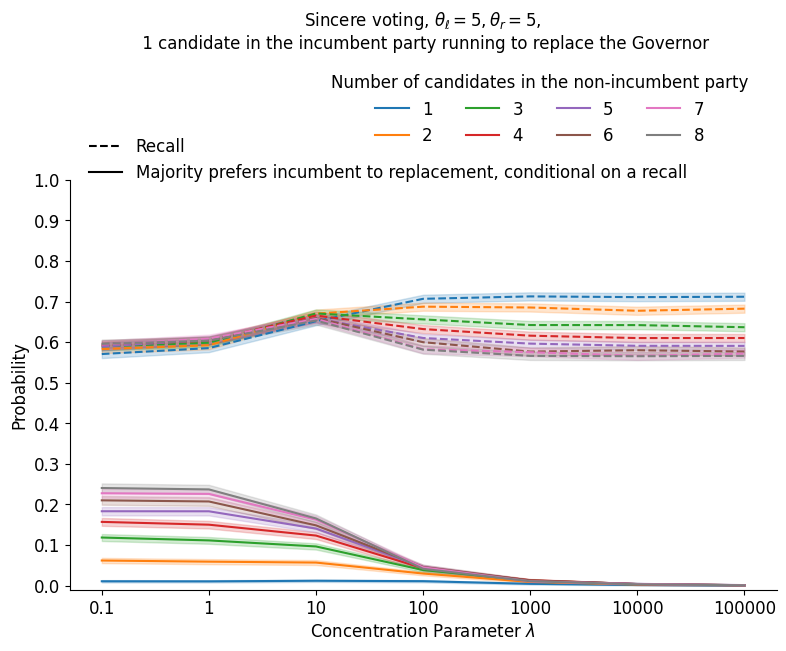

In [255]:
# 1) Configuration

theta_l = 5
theta_r = 5
manipulation_level = 1.0
recall_decision_type = 'sincere' #'sincere' #'strategic'
replacement_rule = 'sincere' #'sincere' 'strategic-top-two'
num_incumbent_cands=2

if theta_l == theta_r == 50:
    main_dir = f'multiple_candidates2' 
else: 
    main_dir = f'left_right_split_{theta_l}_{theta_r}_v2' 
if recall_decision_type == 'sincere':
    initial_title = f'Sincere voting, $\\theta_\ell={theta_l}, \\theta_r={theta_r}$, '
else: 
    initial_title = f'Strategic voting, manipulation level ${int(manipulation_level)}$, $\\theta_\ell={theta_l}, \\theta_r={theta_r}$, '
#'strategic-top-two'
opponent_sizes = [1, 2, 3, 4, 5, 6, 7, 8]
std_str        = '0.5'

# 2) Read & concatenate
all_dfs = []
for opp in opponent_sizes:
    if main_dir == 'multiple_candidates2':
        sub_dir = f'incumbent{num_incumbent_cands}_opposition{opp}/data'
    else:
        sub_dir = f'.' #'.' #'incumbent2_opposition{opp}/data'
    pattern = f'{main_dir}/{sub_dir}/recall_data_{manipulation_level}_{recall_decision_type}_{replacement_rule}_*_{std_str}_{num_incumbent_cands}_{opp}.csv'
    for fp in glob.glob(pattern):
        df_tmp = pd.read_csv(fp)
        # annotate each row with the opponent‐size
        df_tmp['num_cands_opposition_party'] = opp
        all_dfs.append(df_tmp)

# 3) glue them together
df = pd.concat(all_dfs, ignore_index=True).drop_duplicates()

num_incumbent_cands = df["num_cands_incumbent_party"].unique()

if len(num_incumbent_cands) > 1: 
    print(f"Warning: More than one number of incumbent candidates: {num_incumbent_cands}")
else: 
    num_incumbent_cands = num_incumbent_cands[0]

title = f'{initial_title}\n {num_incumbent_cands - 1} candidate in the incumbent party running to replace the Governor'
CONC_PARAMS = [0.1, 1.0, 10.0, 100.0, 1e3, 1e4, 1e5]
OUTFILE     = f'graphs_NEW/all_opponents_incumbents_{num_incumbent_cands}_{recall_decision_type}_{replacement_rule}_{manipulation_level}_{main_dir}.pdf'

plot_conditional_for_opponents(
    df,
    x_labels=CONC_PARAMS,
    title = title,
    filename=OUTFILE
)


In [258]:
main_dir = 'multiple_candidates2'

dfs = []
for f in glob.glob(f'{main_dir}/*/data/*.csv'):
    dfs.append(pd.read_csv(f))
df = pd.concat(dfs, ignore_index=True)

# find all rows with manipulation_level == 1.0 and recall_decision_type == 'sincere'

incumbent_sizes = [2, 3, 4, 5, 6, 7, 8]
opponent_sizes = [1, 2, 3, 4, 5, 6, 7, 8]

sim_types = [
    (1.0, 'sincere', 'sincere'),
    (1.0, 'strategic', 'strategic-top-two'),
    (0.0, 'strategic', 'strategic-top-two'),
]
concentraton_parameters = [
    0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0
]

missing_data = {stype: [] for stype in sim_types}
existing_data = {stype: [] for stype in sim_types}
for num_incumbent_cands in incumbent_sizes:
    for num_opponent_cands in opponent_sizes:
        print(f'Processing: num_incumbent_cands={num_incumbent_cands}, num_opponent_cands={num_opponent_cands}')

        for manipulation_level, recall_decision_type, replacement_rule in sim_types:
            for cp in concentraton_parameters:
                
                # filter the dataframe for the current parameters
                df_filtered = df[
                    (df['num_cands_incumbent_party'] == num_incumbent_cands) &
                    (df['num_cands_opposition_party'] == num_opponent_cands) &
                    (df['manipulation_level'] == manipulation_level) &
                    (df['recall_decision_type'] == recall_decision_type) &
                    (df['replacement_rule'] == replacement_rule) &
                    (df['concentration_parameter'] == cp)
                ]
                if df_filtered.empty:
                    #print(f"\tNo data for num_incumbent_cands={num_incumbent_cands}, num_opponent_cands={num_opponent_cands}, manipulation_level={manipulation_level}, recall_decision_type={recall_decision_type}, replacement_rule={replacement_rule}, concentration_parameter={cp}")
                    missing_data[(manipulation_level, recall_decision_type, replacement_rule)].append(
                        (num_incumbent_cands, num_opponent_cands, cp)
                    )
                elif len(df_filtered) > 1:
                    print(f"\tWarning: More than one row for num_incumbent_cands={num_incumbent_cands}, num_opponent_cands={num_opponent_cands}, manipulation_level={manipulation_level}, recall_decision_type={recall_decision_type}, replacement_rule={replacement_rule}, concentration_parameter={cp}")
                elif len(df_filtered) == 1:
                    existing_data[(manipulation_level, recall_decision_type, replacement_rule)].append(
                        (num_incumbent_cands, num_opponent_cands, cp)
                    )
                    #print(f"\tData exists for num_incumbent_cands={num_incumbent_cands}, num_opponent_cands={num_opponent_cands}, manipulation_level={manipulation_level}, recall_decision_type={recall_decision_type}, replacement_rule={replacement_rule}, concentration_parameter={cp}")
print("Missing data:")
missing_all = {stype: [] for stype, missing in missing_data.items()}
missing_partial = {stype: [] for stype, missing in missing_data.items()}
for stype, missing in missing_data.items():
    if missing:
        missing_entries = [tuple(e[0:2]) for e in missing]
        for entry in missing:
            _e = tuple(entry[0:2])
            if missing_entries.count(_e) == 7:
                missing_all[stype].append(_e)
            else:
                missing_partial[stype].append(entry)

for stype, missing in missing_all.items():
    if missing:
        _missing = list(set(missing))
        print(f"{stype}: {len(_missing)} missing entries")
        for entry in sorted(_missing):
            print(f"\t{entry}")
print()
for stype, missing in missing_partial.items():
    if missing:
        print(f"{stype}: {len(missing)} partial missing entries")
        for entry in missing:
            print(f"\t{entry}")
# print("\n\nExisting data:")
# for stype, existing in existing_data.items():
#     if existing:
#         print(f"{stype}: {len(missing)} missing entries")
#         missing_entries = [tuple(e[0:2]) for e in existing]
#         #print(missing_entries.count())
#         for entry in existing:
#             _e = tuple(entry[0:2])
#             print(f"\t{_e} {missing_entries.count(_e)}")



Processing: num_incumbent_cands=2, num_opponent_cands=1
Processing: num_incumbent_cands=2, num_opponent_cands=2
Processing: num_incumbent_cands=2, num_opponent_cands=3
Processing: num_incumbent_cands=2, num_opponent_cands=4
Processing: num_incumbent_cands=2, num_opponent_cands=5
Processing: num_incumbent_cands=2, num_opponent_cands=6
Processing: num_incumbent_cands=2, num_opponent_cands=7
Processing: num_incumbent_cands=2, num_opponent_cands=8
Processing: num_incumbent_cands=3, num_opponent_cands=1
Processing: num_incumbent_cands=3, num_opponent_cands=2
Processing: num_incumbent_cands=3, num_opponent_cands=3
Processing: num_incumbent_cands=3, num_opponent_cands=4
Processing: num_incumbent_cands=3, num_opponent_cands=5
Processing: num_incumbent_cands=3, num_opponent_cands=6
Processing: num_incumbent_cands=3, num_opponent_cands=7
Processing: num_incumbent_cands=3, num_opponent_cands=8
Processing: num_incumbent_cands=4, num_opponent_cands=1
Processing: num_incumbent_cands=4, num_opponent_

In [ ]:
main_dir       = 'left_right_split_5_5_v2' #'left_right_split_45_55_v2'
std_str        = '0.5'
manipulation_level = 1.0
recall_decision_type = 'sincere' #'sincere' #'strategic'
replacement_rule = 'sincere' #'sincere' #'strategic-top-two'
sim_types = [
    (1.0, 'sincere', 'sincere'),
    (1.0, 'strategic', 'strategic-top-two'),
    (0.0, 'strategic', 'strategic-top-two'),
]
opponent_sizes = [1, 2, 3, 4, 5, 6, 7, 8]
concentraton_parameters = [
    0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0
]

num_missing = 0
for manipulation_level, recall_decision_type, replacement_rule in sim_types: 
    for opp in opponent_sizes: 
        for cp in concentraton_parameters: 
            csv_file = f'{main_dir}/{sub_dir}/recall_data_{manipulation_level}_{recall_decision_type}_{replacement_rule}_{cp}_{std_str}_2_{opp}.csv'
            
            if not os.path.exists(csv_file):
                num_missing += 1
                print(csv_file)
                print(f"opp: {opp}")
                print(f"cp: {cp}")
                print(f"manipulation_level: {manipulation_level}")
                print(f"recall_decision_type: {recall_decision_type}")
                print(f"replacement_rule: {replacement_rule}")
                print()
                
print(f"\nMISSING: {num_missing}")

In [257]:
# match all directories in multiple_candidates2 with the pattern
for f in glob.glob(f'multiple_candidates2/incumbent?_opposition?/data/*.csv'):
    # copy the file to the new directory
    new_dir = f'webapp/data/50_50/'
    # copy f to new_dir
    os.makedirs(new_dir, exist_ok=True)
    new_file = os.path.join(new_dir, os.path.basename(f))
    if not os.path.exists(new_file):
        print(f"Copying {f} to {new_file}")
        os.system(f'cp {f} {new_file}')
    else:
        print(f"{new_file} already exists, skipping.")


Copying multiple_candidates2/incumbent3_opposition5/data/recall_data_1.0_strategic_strategic-top-two_1000.0_0.5_3_5.csv to webapp/data/50_50/recall_data_1.0_strategic_strategic-top-two_1000.0_0.5_3_5.csv
Copying multiple_candidates2/incumbent3_opposition5/data/recall_data_1.0_sincere_sincere_10000.0_0.5_3_5.csv to webapp/data/50_50/recall_data_1.0_sincere_sincere_10000.0_0.5_3_5.csv
Copying multiple_candidates2/incumbent3_opposition5/data/recall_data_1.0_strategic_strategic-top-two_100.0_0.5_3_5.csv to webapp/data/50_50/recall_data_1.0_strategic_strategic-top-two_100.0_0.5_3_5.csv
Copying multiple_candidates2/incumbent3_opposition5/data/recall_data_1.0_strategic_strategic-top-two_10000.0_0.5_3_5.csv to webapp/data/50_50/recall_data_1.0_strategic_strategic-top-two_10000.0_0.5_3_5.csv
Copying multiple_candidates2/incumbent3_opposition5/data/recall_data_0.0_strategic_strategic-top-two_100000.0_0.5_3_5.csv to webapp/data/50_50/recall_data_0.0_strategic_strategic-top-two_100000.0_0.5_3_5.cs

In [87]:
def plot_with_error2(df,
                    x_col,
                    x_labels,
                    y_columns,
                    error_columns,
                    filename,
                    xlabel=None):
    fontsize = 12

    # filter & sort on whatever x_col you pass in
    df_sorted = df[df[x_col].isin(x_labels)].copy()
    df_sorted['x_order'] = df_sorted[x_col].apply(lambda x: x_labels.index(x))
    df_sorted = df_sorted.sort_values('x_order')

    x_values = np.arange(len(x_labels))
    plt.figure(figsize=(8, 6))

    for y_col, err_col in zip(y_columns, error_columns):
        y_vals = np.nan_to_num(pd.to_numeric(df_sorted[y_col], errors='coerce'))
        plt.plot(x_values, y_vals, marker='o', label=y_col)
        if err_col:
            err_vals = np.nan_to_num(pd.to_numeric(df_sorted[err_col], errors='coerce'))
            plt.fill_between(x_values,
                             y_vals - err_vals,
                             y_vals + err_vals,
                             alpha=0.2)

    # format the x-tick labels
    labels = [str(int(l)) if l == int(l) else str(l) for l in x_labels]
    plt.xticks(x_values, labels, rotation=0, fontsize=fontsize)
    plt.yticks(fontsize=fontsize)

    plt.xlabel(xlabel or x_col, fontsize=fontsize)
    plt.ylabel('Frequency', fontsize=fontsize)
    plt.ylim(-0.01, 1)
    plt.legend(frameon=False, loc='upper center', fontsize=fontsize)
    sns.despine()
    plt.grid(False)
    plt.tight_layout()
    plt.savefig(f"{filename}")
    plt.show()


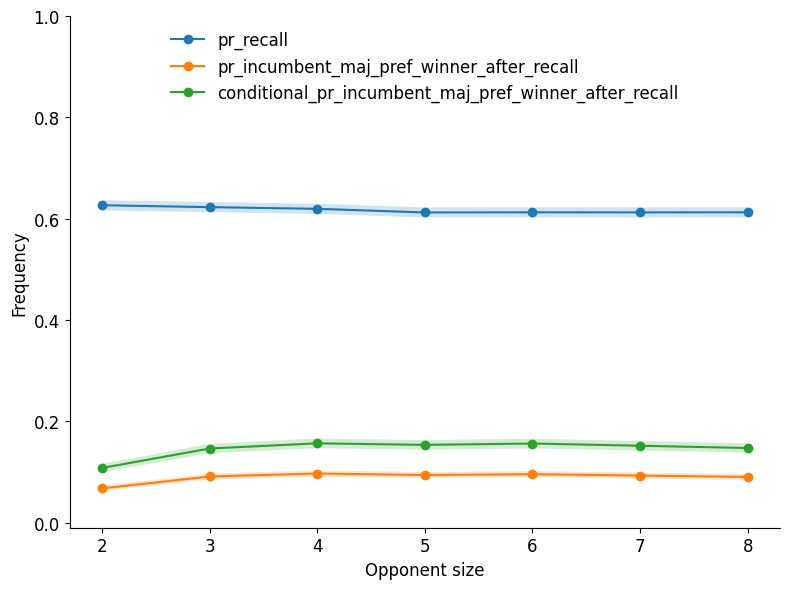

Saved: graphs_NEW/sincere_sincere_manip1.0_conc10.0.pdf


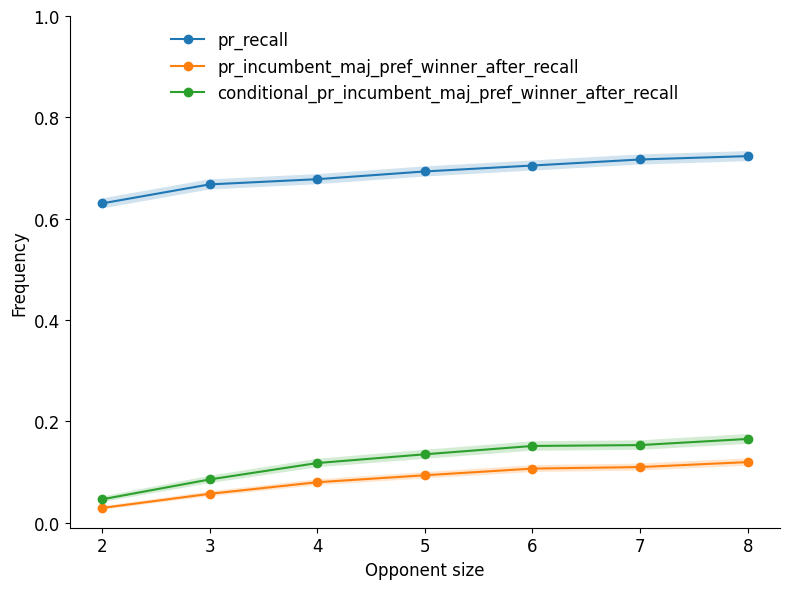

Saved: graphs_NEW/strategic_strategic-top-two_manip1.0_conc10.0.pdf


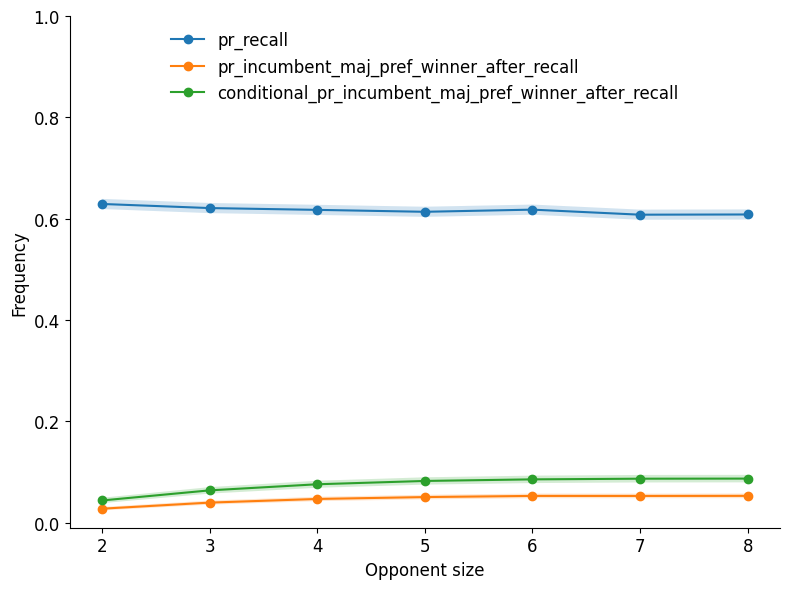

Saved: graphs_NEW/strategic_strategic-top-two_manip0.0_conc10.0.pdf


In [10]:
import glob
import pandas as pd


# ——— CONFIG ———
main_dir            = 'multiple_candidates2'
std_str             = '0.5'
OPPONENT_SIZES      = [2, 3, 4, 5, 6, 7, 8]
FIXED_CONC_PARAM    = 10.0   # ← change this to whichever concentration_parameter you want

graph_types = [
    (1.0, 'sincere',    'sincere'),
    (1.0, 'strategic',  'strategic-top-two'),
    (0.0, 'strategic',  'strategic-top-two'),
]

# the three series you want to plot
y_columns     = [
    "pr_recall",
    "pr_incumbent_maj_pref_winner_after_recall",
    "conditional_pr_incumbent_maj_pref_winner_after_recall",
]
error_columns = [
    "err_recall_events",
    "err_incumbent_maj_pref_winner_after_recall_events",
    "err_conditional_pr_incumbent_maj_pref_winner_after_recall",
]

for manipulation_level, recall_decision_type, replacement_rule in graph_types:
    # collect one row per opponent size
    rows = []
    for opp_size in OPPONENT_SIZES:
        sub_dir = f'incumbent2_opposition{opp_size}'
        csv_path = f"{main_dir}/{sub_dir}/data"
        
        # read and concatenate all CSV summaries in that folder
        dfs = [pd.read_csv(fp) for fp in glob.glob(f"./{csv_path}/*_{std_str}_*.csv")]
        df_sub = pd.concat(dfs, ignore_index=True).drop_duplicates()
        
        # filter to exactly one row for your fixed conc. param
        df_sub = df_sub[
            (df_sub['concentration_parameter'] == FIXED_CONC_PARAM) &
            (df_sub['manipulation_level']      == manipulation_level) &
            (df_sub['recall_decision_type']    == recall_decision_type) &
            (df_sub['replacement_rule']        == replacement_rule)
        ].copy()
        
        # compute your conditional probability and its diff
        df_sub['conditional_probability']   = (
            df_sub['pr_incumbent_maj_pref_winner_after_recall']
            / df_sub['pr_recall']
        )
        df_sub['conditional_prob_diff']     = (
            df_sub['conditional_probability']
            - df_sub['conditional_pr_incumbent_maj_pref_winner_after_recall']
        )
        
        # tag the opponent size so we can plot it on the x-axis
        df_sub['opponent_size'] = opp_size
        
        rows.append(df_sub)
    
    # assemble one DataFrame with one row per opponent_size
    df_plot = pd.concat(rows, ignore_index=True)
    
    # x-axis values
    x_labels = OPPONENT_SIZES
    
    # build filename & title
    filename = (
        f"graphs_NEW/"
        f"{recall_decision_type}_{replacement_rule}_"
        f"manip{manipulation_level}_conc{FIXED_CONC_PARAM}.pdf"
    )
    title = (
        f"Opponents vs Metric — recall={recall_decision_type}, "
        f"rule={replacement_rule}, manip={manipulation_level}, "
        f"conc={FIXED_CONC_PARAM}"
    )
    
    plot_with_error2(
        df_plot,
        x_col='opponent_size',
        x_labels=OPPONENT_SIZES,
        y_columns=y_columns,
        error_columns=error_columns,
        filename=filename,
        xlabel='Opponent size'
    )
    
    print(f"Saved: {filename}")


FileNotFoundError: [Errno 2] No such file or directory: 'graphs/graphs_NEW/incumbent2_opposition2_std0.5_sim_diff_probs_sincere_sincere_1.0.pdf'

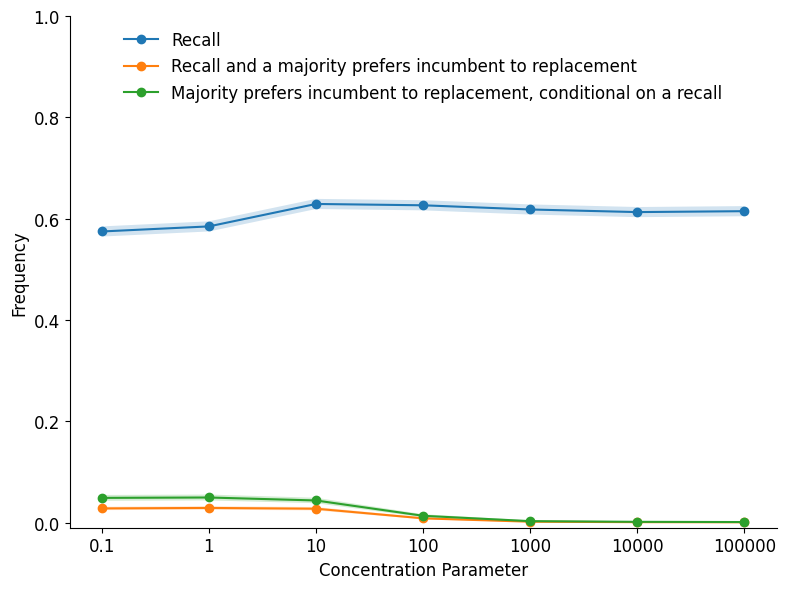

In [30]:


# Define x-axis labels in the correct order
x_labels = sorted(df['concentration_parameter'])

# Function to plot specified y-values with error bars on the same graph
def plot_with_error(df, x_labels, y_columns, error_columns, filename):

    fontsize = 12
    # Filter and sort the data to match x_labels order
    df_sorted = df[df['concentration_parameter'].isin(x_labels)].copy()
    df_sorted['x_order'] = df_sorted['concentration_parameter'].apply(lambda x: x_labels.index(x))
    df_sorted = df_sorted.sort_values('x_order')

    # Create numerical indices for x-axis
    x_values = np.arange(len(x_labels))

    # Plotting setup
    plt.figure(figsize=(8, 6))

    # Iterate over each y-value and error column to plot them
    for y_column, error_column in zip(y_columns, error_columns):
        # Extract relevant y-values and error values
        pr_values = df_sorted[y_column].values


        # Convert to numeric and ensure finite values
        pr_values = np.nan_to_num(pd.to_numeric(pr_values, errors='coerce'), nan=0.0, posinf=0.0, neginf=0.0)

        # Plot the data with shaded error regions
        plt.plot(x_values, pr_values, marker='o', label="Recall" if y_column == 'pr_recall' else ("Majority prefers incumbent to replacement, conditional on a recall" if y_column == "conditional_pr_incumbent_maj_pref_winner_after_recall" else "Recall and a majority prefers incumbent to replacement"))

        if error_column != "":
            error_values = df_sorted[error_column].values
            error_values = np.nan_to_num(pd.to_numeric(error_values, errors='coerce'), nan=0.0, posinf=0.0, neginf=0.0)
            plt.fill_between(x_values, pr_values - error_values, pr_values + error_values, alpha=0.2)

    # Formatting the plot
    # Convert x_labels to remove trailing .0 if present
    formatted_labels = [str(int(label)) if label == int(label) else str(label) for label in x_labels]
    plt.xticks(x_values, formatted_labels, rotation=0, fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.xlabel('Concentration Parameter', fontsize=fontsize)
    plt.ylabel('Frequency', fontsize=fontsize)
    plt.ylim(-0.01, 1)
    plt.title('') #f'{title}')


    plt.legend(frameon=False, loc='upper center', fontsize=fontsize)#, bbox_to_anchor=(0.15, 1))   
    sns.despine()
    plt.grid(False)
    plt.tight_layout()
    plt.savefig(f"graphs/{filename}")
    # Display the plot
    plt.show()

# Specify the column names for y-values and errors
y_columns = [
    "pr_recall", 
    "pr_incumbent_maj_pref_winner_after_recall", 
    "conditional_pr_incumbent_maj_pref_winner_after_recall"
    ]
error_columns = [
    "err_recall_events", 
    "err_incumbent_maj_pref_winner_after_recall_events", 
    "err_conditional_pr_incumbent_maj_pref_winner_after_recall"
    ]

# Call the plotting function
plot_with_error(df, x_labels, y_columns, error_columns, filename)


5_5_sim_diff_probs_sincere_sincere_1.0.pdf


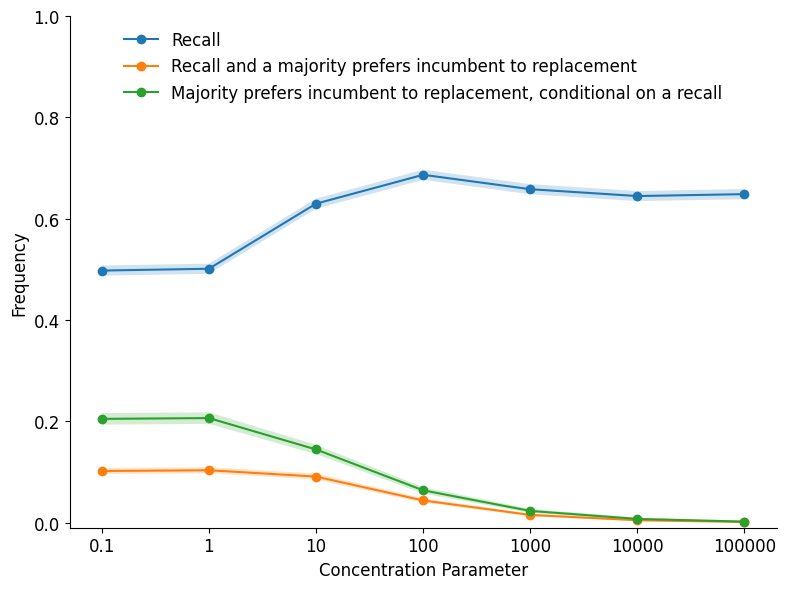

5_5_sim_diff_probs_strategic_strategic-top-two_1.0.pdf


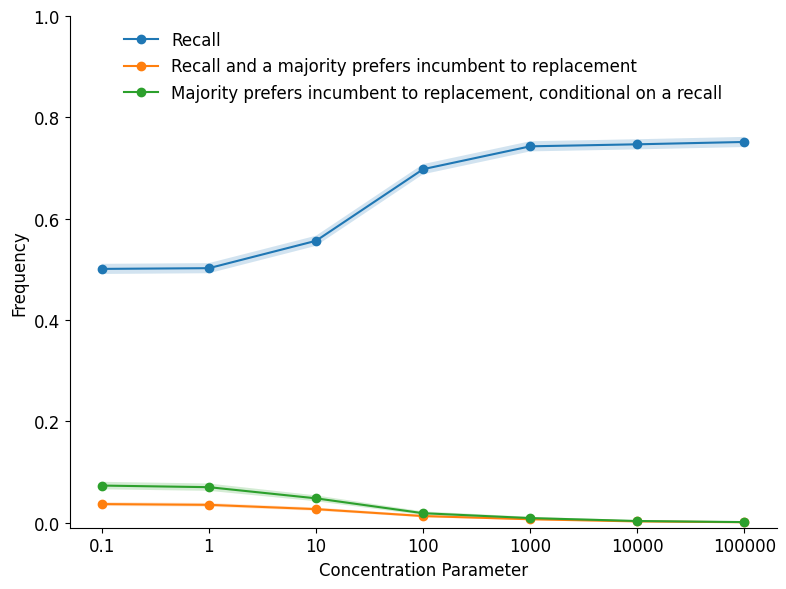

5_5_sim_diff_probs_strategic_strategic-top-two_0.0.pdf


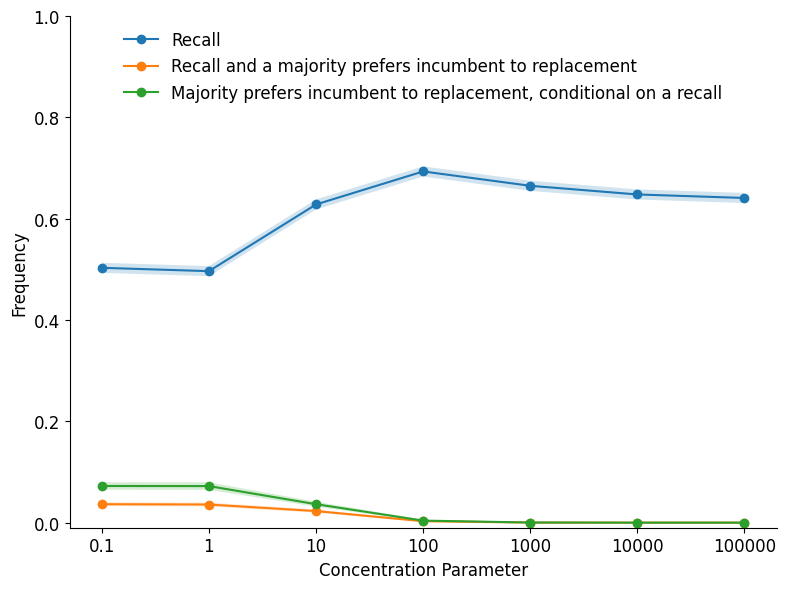

In [31]:
left_right_split='5_5'

csv_data =  f'left_right_split_{left_right_split}/data_{left_right_split}' #f'data_{left_right_split}'

for (manipulation_level, recall_decision_type, replacement_rule) in [(1.0, 'sincere', 'sincere'), (1.0, 'strategic', 'strategic-top-two'), (0.0, 'strategic', 'strategic-top-two'), ]:
    filename = f'{left_right_split}_sim_diff_probs_{recall_decision_type}_{replacement_rule}_{manipulation_level}.pdf'
    print(filename)
    dfs = []
    for file in glob.glob(f"./{csv_data}/*.csv"):
        df = pd.read_csv(file)
        dfs.append(df)
    df = pd.concat(dfs, ignore_index=True)
    # remove duplicate rows
    df = df.drop_duplicates()

    x_labels = [0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]

    df=df[df['concentration_parameter'].isin(x_labels)]
    df=df[df['recall_decision_type'] == recall_decision_type]
    df=df[df['replacement_rule'] == replacement_rule]
    df=df[df['manipulation_level'] == manipulation_level]


    df['conditional_probability'] = df['pr_incumbent_maj_pref_winner_after_recall'] / df['pr_recall']


    df['conditional_prob_diff'] = df['conditional_probability'] - df['conditional_pr_incumbent_maj_pref_winner_after_recall']

    # Define x-axis labels in the correct order
    x_labels = sorted(df['concentration_parameter'])


    # Specify the column names for y-values and errors
    y_columns = [
        "pr_recall", 
        "pr_incumbent_maj_pref_winner_after_recall", 
        "conditional_pr_incumbent_maj_pref_winner_after_recall"
        ]
    error_columns = [
        "err_recall_events", 
        "err_incumbent_maj_pref_winner_after_recall_events", 
        "err_conditional_pr_incumbent_maj_pref_winner_after_recall"
        ]

    # Call the plotting function
    plot_with_error(df, x_labels, y_columns, error_columns, filename)


## Visualizing a Sample Polarized Election

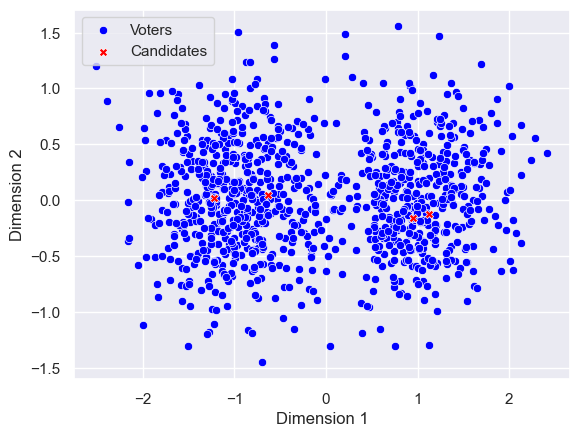

In [62]:
num_dims = 2

num_cands_incumbent_party = 2
num_cands_opposition_party = 2

pr_incumbent_party_voters = 0.5
concentration_param_for_num_voters = 100

num_voters = 1000

# Generate candidate clusters
cand_clusters = [
    ((-1, 0), generate_covariance(num_dims, 0.15, 0), num_cands_incumbent_party),  # Incumbent party
    ((1, 0), generate_covariance(num_dims, 0.15, 0), num_cands_opposition_party),  # Opposition party
]

# Generate voter clusters
v_size_incumbent, v_size_opposition = np.random.dirichlet([
    pr_incumbent_party_voters * concentration_param_for_num_voters, 
    (1 - pr_incumbent_party_voters) * concentration_param_for_num_voters
])

voter_clusters = [
    ((-1, 0), generate_covariance(num_dims, 0.5, 0), int(num_voters * v_size_incumbent)),  # Incumbent voters
    ((1, 0), generate_covariance(num_dims, 0.5, 0), int(num_voters * v_size_opposition)),  # Opposition voters
]

# Generate spatial and utility profiles
sprof = generate_spatial_profile_polarized(cand_clusters, voter_clusters, cluster_types = ["incumbent party", "opposition party"])

sprof.view()

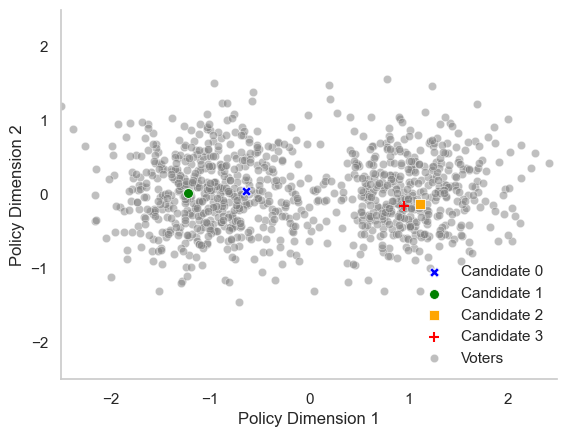

In [63]:
# white background

sns.set_style("whitegrid")
sprof_to_display = sprof
# Scatter plots
sns.scatterplot(
    x=[sprof_to_display.voter_position(v)[0] for v in sprof_to_display.voters], 
    y=[sprof_to_display.voter_position(v)[1] for v in sprof_to_display.voters], 
    color="gray", alpha=0.5, label="Voters"
)

cand = 0
sns.scatterplot(
    x=[sprof_to_display.candidate_position(cand)[0]], 
    y=[sprof_to_display.candidate_position(cand)[1]], 
    color="blue", marker='X', s=50, label="Candidate 0"
)

cand = 1
sns.scatterplot(
    x=[sprof_to_display.candidate_position(cand)[0]], 
    y=[sprof_to_display.candidate_position(cand)[1]], 
    color="green", marker='o', s=50, label="Candidate 1"
)

cand = 2
sns.scatterplot(
    x=[sprof_to_display.candidate_position(cand)[0]], 
    y=[sprof_to_display.candidate_position(cand)[1]], 
    color="red", marker='+', linewidth=1.5, s=50, label="Candidate 3"
)

cand = 3
sns.scatterplot(
    x=[sprof_to_display.candidate_position(cand)[0]], 
    y=[sprof_to_display.candidate_position(cand)[1]], 
    color="orange", marker='s', label="Candidate 2", s=50
)

# Set labels for axes
plt.xlabel('Policy Dimension 1')
plt.ylabel('Policy Dimension 2')

# Retrieve and reorder legend handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 2, 4, 3, 0]  # Example order: "Candidate 1", "Candidate 2", "Candidate 4", "Candidate 3", "Voters"

# Apply reordered legend
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], frameon=False)

plt.ylim(-2.5, 2.5)
plt.xlim(-2.5, 2.5)
plt.grid(False)
sns.despine()

# Save and show the plot
plt.savefig("graphs/polarized_spatial_profile_0.5.pdf", bbox_inches='tight')
plt.show()
